In [76]:
import nibabel as nib
import matplotlib.pyplot as plt

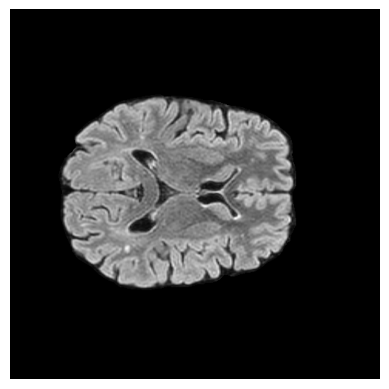

In [87]:
T1_img = nib.load(r"/home/mannon/Downloads/27919209/MSLesSeg_RAW/P3/T1/P3_T1_FLAIR.nii.gz").get_fdata()
plt.imshow(T1_img[:, :, 50], cmap='gray' ) #showing the middle slice
plt.axis('off')
plt.show()

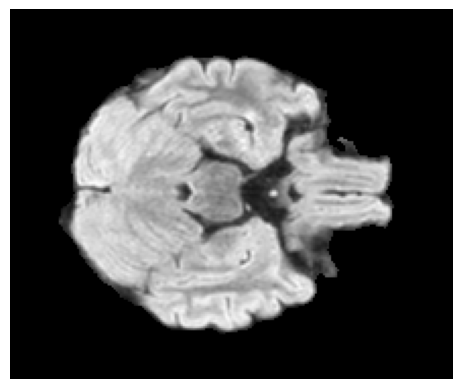

In [85]:
T1_img = nib.load(r"_mni1mm_aff12_brain.nii.gz").get_fdata()
plt.imshow(T1_img[:, :, 50], cmap='gray' ) #showing the middle slice
plt.axis('off')
plt.show()

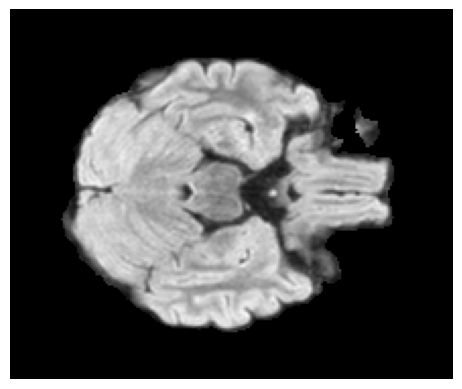

In [86]:
T1_img = nib.load(r"/home/mannon/Downloads/27919209/MSLesSeg Dataset/train/P3/T1/P3_T1_FLAIR.nii.gz").get_fdata()
plt.imshow(T1_img[:, :, 50], cmap='gray' ) #showing the middle slice
plt.axis('off')
plt.show()

In [80]:
import os
from nipype.interfaces.fsl import FLIRT, BET

def flirt_to_mni_affine_12dof(
    in_nii: str,
    ref_mni_1mm: str,
    out_nii: str,
    out_mat: str,
    cost: str = "corratio",
    interp: str = "trilinear",
):
    """
    Registers input MRI (any modality) to MNI152 1mm template using FLIRT affine 12 DOF.
    - cost='corratio' is commonly used for intra-MRI; MI is often used for cross-modality.
    """
    flt = FLIRT()
    flt.inputs.in_file = in_nii
    flt.inputs.reference = ref_mni_1mm
    flt.inputs.out_file = out_nii
    flt.inputs.out_matrix_file = out_mat
    flt.inputs.dof = 12
    flt.inputs.cost = cost
    flt.inputs.interp = interp
    res = flt.run()
    return res

def bet_brain_extract(
    in_nii: str,
    out_brain_nii: str,
    out_mask_nii: str,
    frac: float = 0.35,
    robust: bool = True,
):
    """
    Brain extraction using FSL BET.
    Outputs:
      - brain-extracted image
      - binary mask
    """
    bet = BET()
    bet.inputs.in_file = in_nii
    bet.inputs.out_file = out_brain_nii
    bet.inputs.mask = True              # tells BET to write a mask
    bet.inputs.frac = frac              # tweak per dataset (0.2–0.5 typical)
    bet.inputs.robust = robust          # more robust brain center estimation
    res = bet.run()

    # Nipype writes mask as out_file with suffix "_mask" typically:
    # e.g. out_brain_nii = "subj_brain.nii.gz" -> "subj_brain_mask.nii.gz"
    # We'll move/rename it if needed.
    generated_mask = bet._list_outputs().get("mask_file", None)
    if generated_mask and generated_mask != out_mask_nii:
        os.replace(generated_mask, out_mask_nii)

    return res

def coreg_to_mni_then_bet(
    in_nii: str,
    ref_mni_1mm: str,
    out_prefix: str,
    cost: str = "corratio",
):
    """
    1) FLIRT affine 12 DOF to MNI152 1mm
    2) BET on the registered output (creates mask too)
    """
    out_reg = f"{out_prefix}_mni1mm_aff12.nii.gz"
    out_mat = f"{out_prefix}_to_mni_aff12.mat"

    flirt_to_mni_affine_12dof(
        in_nii=in_nii,
        ref_mni_1mm=ref_mni_1mm,
        out_nii=out_reg,
        out_mat=out_mat,
        cost=cost,
        interp="trilinear",
    )

    out_brain = f"{out_prefix}_mni1mm_aff12_brain.nii.gz"
    out_mask = f"{out_prefix}_mni1mm_aff12_brainmask.nii.gz"

    bet_brain_extract(
        in_nii=out_reg,
        out_brain_nii=out_brain,
        out_mask_nii=out_mask,
        frac=0.35,
        robust=True,
    )

    return {
        "registered": out_reg,
        "affine_mat": out_mat,
        "brain": out_brain,
        "mask": out_mask,
    }


In [81]:
res = coreg_to_mni_then_bet(
    in_nii= r"/home/mannon/Downloads/27919209/MSLesSeg_RAW/P3/T1/P3_T1_FLAIR.nii.gz",
    ref_mni_1mm=r"/home/mannon/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz",
    out_prefix="",
    cost="mutualinfo",
)